# Identifying Pneumonina using Convolutional Neural Networks

- Student Name: Kevin Spring
- Student pace: Flex
- Scheduled Project Review: December 12, 2022
- Instructor name: Morgan Jones
- Blog Post

# Summary


# Table of Contents

# Introduction

# Methodology

## Data

In [2]:
# Download the data.zip file and unpack it into test-train split using python_splitter
import os
#from python_splitter import split_from_folder # https://github.com/bharatadk/python_splitter

# absolute path of unzipped data directory
PATH = os.path.join(os.path.abspath(os.getcwd()),'data/')
#split_from_folder(PATH, train = 0.6, test=0.2, val=0.2)

In [4]:
PATH

'/home/kevinspring/Documents/Flatiron/phase04/Pneumonia-detection-using-CNN/data/'

In [5]:
def file_count2(dir_path, class_name):
    count = 0
    for path in os.scandir(dir_path):
        if path.is_file():
            count += 1
    print(f'{class_name} file count: {count}')
    
file_count2(PATH, 'NORMAL')
file_count2(PATH, 'PNEUMONIA')

NORMAL file count: 1
PNEUMONIA file count: 1


# Data Description
The data consists of chest x-ray images of those that have pneumonia and those that do not (normal).
There is a total of 5,856 images of which 27% are in the normal class and 73% are in the pneumonia
class. This data is imbalanced and predicting that any chest x-ray is in the pneumonia class would
have an accuracy of 73%.

In [6]:
import os, shutil

data_path = os.path.join(os.path.abspath(os.getcwd()),'Train_Test_Folder/')
print(data_path)

train_dir = os.path.join(data_path, 'train/')
test_dir = os.path.join(data_path, 'test/')

train_normal = os.path.join(train_dir, 'NORMAL/')
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA/')

/home/kevinspring/Documents/Flatiron/phase04/Pneumonia-detection-using-CNN/Train_Test_Folder/


Image number: 1266
normal picture title:  NORMAL2-IM-1109-0001.jpeg
pneumonia picture title: person1644_bacteria_4362.jpeg


Text(0.5, 1.0, 'Pneumonia')

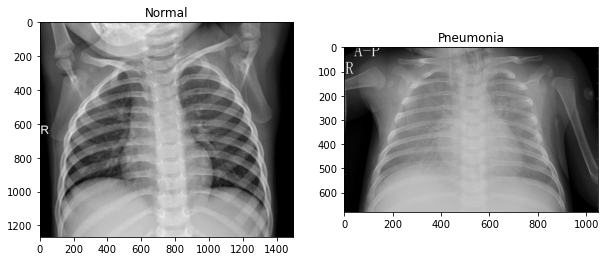

In [7]:
# Show a representative image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print(f'Image number: {len(os.listdir(train_normal))}')
rand_norm = np.random.randint(0, len(os.listdir(train_normal)))
norm_img = os.listdir(train_normal)[rand_norm]
print('normal picture title: ', norm_img)
norm_img_address = train_normal+norm_img

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_pneumonia)))

pneu_img =  os.listdir(train_pneumonia)[rand_norm]
pneu_img_address = train_pneumonia+pneu_img
print('pneumonia picture title:', pneu_img)

# Load the image
norm_load = Image.open(norm_img_address)
pneu_load = Image.open(pneu_img_address)

# Show the picture
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap='gray')
ax1.set_title('Normal')

ax2 = fig.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneu_load, cmap='gray')
ax2.set_title('Pneumonia')

In [9]:
# Import data into tensorflow Dataset object
from tensorflow.keras.utils import image_dataset_from_directory

img_height = 64
img_width = 64
grayscale = 1
batch_size = 32

train_ds, val_ds = image_dataset_from_directory(train_dir,
                                        color_mode='grayscale',
                                        label_mode='binary',
                                        validation_split=0.2,
                                        subset='both',
                                        seed=42,
                                        #shuffle=False,
                                        image_size=(img_height, img_width),
                                        batch_size = batch_size)

test_ds = image_dataset_from_directory(test_dir,
                                       shuffle=False,
                                       color_mode='grayscale',
                                       label_mode='binary',
                                       image_size=(img_height, img_width)
                                      )

print('Batches for testing -->', test_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())
print('Batches for training -->', train_ds.cardinality())

Found 4684 files belonging to 2 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 2 classes.
Batches for testing --> tf.Tensor(37, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(30, shape=(), dtype=int64)
Batches for training --> tf.Tensor(118, shape=(), dtype=int64)


2022-11-30 12:43:41.397525: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 12:43:41.397752: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
print(train_ds.class_names)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['NORMAL', 'PNEUMONIA']
(32, 64, 64, 1)
(32, 1)


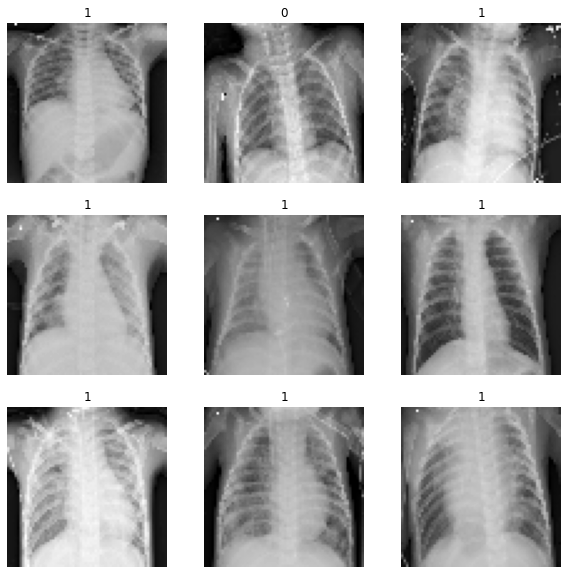

In [13]:
# Visualize the data

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')
        plt.title(int(labels[i]))
        plt.axis('off')

In [ ]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training your model.
# Dataset.prefetch overlaps data preprocessing and model execution while training.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modeling
As this is an image classification problem, I will be using convolutional neural networks. I will start with a baseline model and add regularization if overfitting is a problem. For the last model I will combine a pretrained model.

In [18]:
# libraries for neural networks
#from tensorflow import keras
from tensorflow.keras.models import Sequential
import keras
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Rescaling
from keras.metrics import SpecificityAtSensitivity

In [19]:
def plot_fun(model, epochs):
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'g-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'g-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#plot_fun(baseline_cnn_fit)
# Visualize training results
#plot_fun(cnn_model)

In [31]:
#import tensorflow.keras import layers

batch_size = 32
learning_rate = 3e-4
epochs = 20

# Baseline model
inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
#x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
#x = MaxPooling2D(pool_size=2)(x)
#x = Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model_baseline = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model_baseline.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.5)])

# Summary
model_baseline.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/baseline_model.keras',
        save_best_only=True,
        monitor='val_loss')
]

# Fit model
model_baseline_fit = model_baseline.fit(train_ds,
                                         epochs=epochs,
                                         validation_data = val_ds,
                                         batch_size=batch_size,
                                         callbacks=callbacks)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 1)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 30752)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 30753     
                                                           

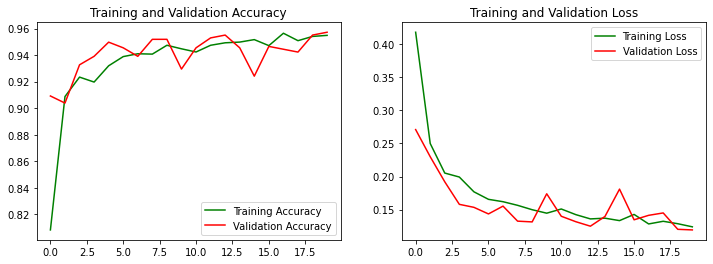

In [32]:
plot_fun(model_baseline_fit, epochs)

## Discussion of model 1
Model 1 is not overfitting so it may not have sufficient power to generalize. For model 2 I will increase the number of layers.

In [41]:
# Model 2
inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model2.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.5)])

# Summary
model2.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='nodels/keras/model2.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 64, 64, 1)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                     

In [42]:
# Fit model
epochs=30
model2_fit = model2.fit(train_ds,
                        steps_per_epoch=len(train_ds),
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         verbose=1)

Epoch 1/30
118/118 [==============================] - 20s 162ms/step - loss: 0.3652 - accuracy: 0.8346 - recall_12: 0.9553 - specificity_at_sensitivity_12: 0.9745 - val_loss: 0.1533 - val_accuracy: 0.9466 - val_recall_12: 0.9652 - val_specificity_at_sensitivity_12: 0.9959
Epoch 2/30
118/118 [==============================] - 20s 165ms/step - loss: 0.1648 - accuracy: 0.9376 - recall_12: 0.9575 - specificity_at_sensitivity_12: 0.9971 - val_loss: 0.1305 - val_accuracy: 0.9562 - val_recall_12: 0.9855 - val_specificity_at_sensitivity_12: 0.9959
Epoch 3/30
118/118 [==============================] - 20s 168ms/step - loss: 0.1565 - accuracy: 0.9378 - recall_12: 0.9622 - specificity_at_sensitivity_12: 0.9931 - val_loss: 0.1632 - val_accuracy: 0.9412 - val_recall_12: 0.9971 - val_specificity_at_sensitivity_12: 0.9959
Epoch 4/30
118/118 [==============================] - 20s 168ms/step - loss: 0.1388 - accuracy: 0.9453 - recall_12: 0.9659 - specificity_at_sensitivity_12: 0.9980 - val_loss: 0.1278

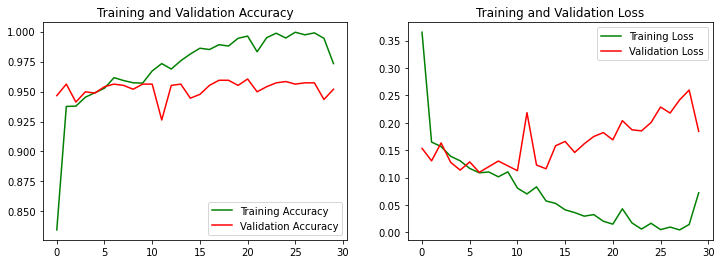

In [43]:
plot_fun(model2_fit, epochs)

## Discussion
Model 2 is able to overfit. This means that the model has the statistical power to generlize and not be underfitted. The next goal is to maximize generalization performance. I will use a dropout layer to regularize.

In [47]:
# Model 3
# Include a dropout
from keras.layers import Dropout

#learning_rate = 0.001
#batch_size=32

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model3.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.5)])

# Summary
model3.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model3.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 64, 64, 1)         0         
                                                                 
 conv2d_32 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                     

Epoch 1/20
118/118 [==============================] - 18s 145ms/step - loss: 0.3525 - accuracy: 0.8375 - recall_14: 0.9622 - specificity_at_sensitivity_14: 0.9804 - val_loss: 0.1859 - val_accuracy: 0.9284 - val_recall_14: 0.9870 - val_specificity_at_sensitivity_14: 0.9959
Epoch 2/20
118/118 [==============================] - 18s 150ms/step - loss: 0.1621 - accuracy: 0.9362 - recall_14: 0.9622 - specificity_at_sensitivity_14: 0.9980 - val_loss: 0.1239 - val_accuracy: 0.9541 - val_recall_14: 0.9638 - val_specificity_at_sensitivity_14: 0.9959
Epoch 3/20
118/118 [==============================] - 19s 155ms/step - loss: 0.1493 - accuracy: 0.9456 - recall_14: 0.9670 - specificity_at_sensitivity_14: 0.9922 - val_loss: 0.1234 - val_accuracy: 0.9509 - val_recall_14: 0.9638 - val_specificity_at_sensitivity_14: 0.9959
Epoch 4/20
118/118 [==============================] - 19s 154ms/step - loss: 0.1492 - accuracy: 0.9450 - recall_14: 0.9666 - specificity_at_sensitivity_14: 0.9961 - val_loss: 0.1230

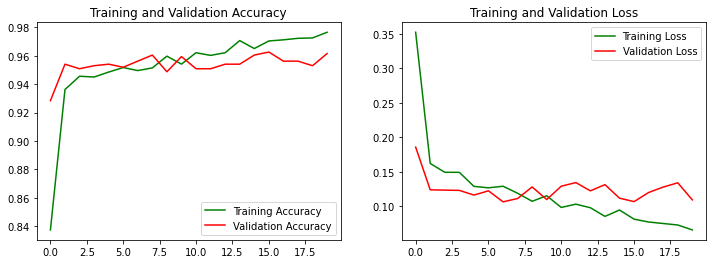

In [48]:
# Fit model
epochs=20
model3_fit = model3.fit(train_ds,
                        #steps_per_epoch=len(train_ds),
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         verbose=1)

plot_fun(model3_fit, epochs)

In [ ]:
# Model 3 discussion
# Including a dropout layer does decrease the overfitting on the training data but validation
# accuracy starts at 100% and bounces around. This may be because there are not enough samples
# in the validation set. 
# In the next model I will augment the data by rotating, flipping, and zooming on the images

In [53]:
# Model 4: Data augmentationl

learning_rate = 0.0005

from keras import layers

data_augmentation = Sequential(
        [
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ])

from keras.layers import Dropout

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model4.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.5)])

# Summary
model4.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model4.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 64, 64, 1)         0         
                                                                 
 rescaling_12 (Rescaling)    (None, 64, 64, 1)         0         
                                                                 
 conv2d_40 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 32, 32, 64)        18496     
                                                          

Epoch 1/30
118/118 [==============================] - 20s 168ms/step - loss: 0.1449 - accuracy: 0.9413 - recall_17: 0.9622 - specificity_at_sensitivity_17: 0.9990 - val_loss: 0.1336 - val_accuracy: 0.9412 - val_recall_17: 0.9420 - val_specificity_at_sensitivity_17: 0.9959
Epoch 2/30
118/118 [==============================] - 21s 177ms/step - loss: 0.1483 - accuracy: 0.9466 - recall_17: 0.9674 - specificity_at_sensitivity_17: 0.9961 - val_loss: 0.1232 - val_accuracy: 0.9498 - val_recall_17: 0.9609 - val_specificity_at_sensitivity_17: 0.9959
Epoch 3/30
118/118 [==============================] - 23s 190ms/step - loss: 0.1452 - accuracy: 0.9442 - recall_17: 0.9655 - specificity_at_sensitivity_17: 0.9961 - val_loss: 0.1279 - val_accuracy: 0.9476 - val_recall_17: 0.9435 - val_specificity_at_sensitivity_17: 0.9959
Epoch 4/30
118/118 [==============================] - 23s 188ms/step - loss: 0.1347 - accuracy: 0.9490 - recall_17: 0.9677 - specificity_at_sensitivity_17: 1.0000 - val_loss: 0.1118

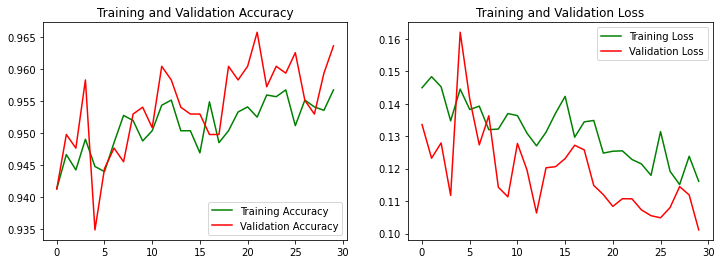

In [61]:
# Fit model
epochs=30
#batch_size = 8
model4_fit = model4.fit(train_ds,
                        steps_per_epoch=len(train_ds),
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks)
plot_fun(model4_fit, epochs)

In [ ]:
# Discussion 5 epochs

In [56]:
# Model with transfer learning
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(img_height, img_width, 3))

conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [57]:
# Model 5
# With a pretrained model

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs)
x = Conv2D(3,(3,3), padding='same')(x)
x = keras.applications.vgg19.preprocess_input(x)
x = conv_base(x)
x = Flatten()(x)
x = Dense(128)(x)
x = Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs, outputs)

# Compile
model5.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/m5_feature_extraction_with_data_augmentation.keras',
        save_best_only=True,
        monitor='val_loss')
]

Epoch 1/30
118/118 [==============================] - 184s 2s/step - loss: 3.4048 - accuracy: 0.7076 - val_loss: 0.5401 - val_accuracy: 0.7372
Epoch 2/30
118/118 [==============================] - 182s 2s/step - loss: 0.5972 - accuracy: 0.7044 - val_loss: 0.4218 - val_accuracy: 0.8312
Epoch 3/30
118/118 [==============================] - 184s 2s/step - loss: 0.4348 - accuracy: 0.7751 - val_loss: 0.7149 - val_accuracy: 0.7372
Epoch 4/30
118/118 [==============================] - 185s 2s/step - loss: 0.4457 - accuracy: 0.7769 - val_loss: 0.9322 - val_accuracy: 0.4829
Epoch 5/30
118/118 [==============================] - 183s 2s/step - loss: 0.4273 - accuracy: 0.7956 - val_loss: 0.3859 - val_accuracy: 0.7853
Epoch 6/30
118/118 [==============================] - 183s 2s/step - loss: 0.3781 - accuracy: 0.8319 - val_loss: 0.6544 - val_accuracy: 0.6688
Epoch 7/30
118/118 [==============================] - 179s 2s/step - loss: 0.3236 - accuracy: 0.8637 - val_loss: 0.3573 - val_accuracy: 0.8173

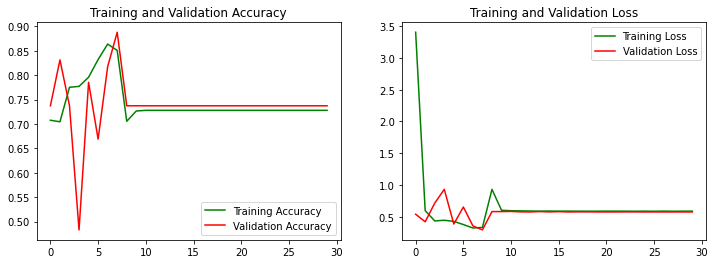

In [58]:
model5_fit = model5.fit(train_ds,
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callback=callbacks)
plot_fun(model5_fit, epochs)

In [62]:
# Analyze models on test data

def model_evaluate(best_model, test_data):
    model = keras.models.load_model(best_model)
    test_loss, test_accuracy, test_recall, test_specificity = model.evaluate(test_data)
    print(f'Test accuracy of {best_model}: {test_accuracy:.3f}')

model_evaluate('models/keras/baseline_model.keras', test_ds)
model_evaluate('models/keras/model2.keras', test_ds)
model_evaluate('models/keras/model3.keras', test_ds)
model_evaluate('models/keras/model4.keras', test_ds)
#model_evaluate('models/keras/m5_feature_extraction_with_data_augmentation.keras', test_ds)

37/37 [==============================] - 2s 64ms/step - loss: 0.1397 - accuracy: 0.9497 - recall_6: 0.9708 - specificity_at_sensitivity_6: 0.9968
Test accuracy of models/keras/baseline_model.keras: 0.950
37/37 [==============================] - 3s 75ms/step - loss: 0.1259 - accuracy: 0.9548 - recall_12: 0.9766 - specificity_at_sensitivity_12: 0.9937
Test accuracy of models/keras/model2.keras: 0.955
37/37 [==============================] - 3s 66ms/step - loss: 0.1341 - accuracy: 0.9505 - recall_14: 0.9708 - specificity_at_sensitivity_14: 0.9937
Test accuracy of models/keras/model3.keras: 0.951
37/37 [==============================] - 3s 67ms/step - loss: 0.1747 - accuracy: 0.9761 - recall_48: 0.9988 - specificity_at_sensitivity_48: 0.9527
Test accuracy of models/keras/model4.keras: 0.976


In [ ]:
# pickle the best model